In [ ]:
#
# Copyright 2018-2019 IBM Corp. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
#

# Object Detection - Visualize Results

This example illustrates the usage of [MAX Object Detector](https://developer.ibm.com/exchanges/models/all/max-object-detector) model. This notebook guides you through running the model on a sample image to get the objects, extracting the bounding boxes and then visualizing them over the image.


## Setup

The notebook calls the `MAX Object Detector` microservice, which must be running. You can either use the [hosted demo instance](http://max-object-detector.max.us-south.containers.appdomain.cloud), or follow the instructions for [deploying the microservice locally from the Dockerhub image](https://github.com/IBM/MAX-Object-Detector#deploy-from-docker-hub). 

In [1]:
# This notebook requires matplotlib, Pillow and requests
# You only need to run the line below to install these if you don't already have them installed

! pip install -q matplotlib Pillow requests

In [2]:
import io
from PIL import Image
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import requests

In [3]:
# This url must point to a running instance of the model microservice
# By default this assumes you are using the hosted demo instance
# If you want to use the model that is running locally, pass the `local_port` field.


def call_model(input_img, local_port=None):
    """
    Takes in input image file path, posts the image to the model and returns face bboxes and emotion predictions
    If local port is not specified, uses the long running instance.
    If local port is specified, uses the local instance.
    """
    if local_port:
        url = 'http://localhost:'+ str(local_port)+'/model/predict'
    else:
        url = 'http://max-object-detector.max.us-south.containers.appdomain.cloud/model/predict'

    #files = {'image': ('image.jpg', open(input_img, 'rb'), 'images/jpeg') }
    files = { 'image': input_img, 'Content-Type': 'multipart/form-data' }
    
    r = requests.post(url, files=files).json()
 
    return r

## Step 1: Visualizing the test image

First we load the image with Pillow and display the image in our notebook

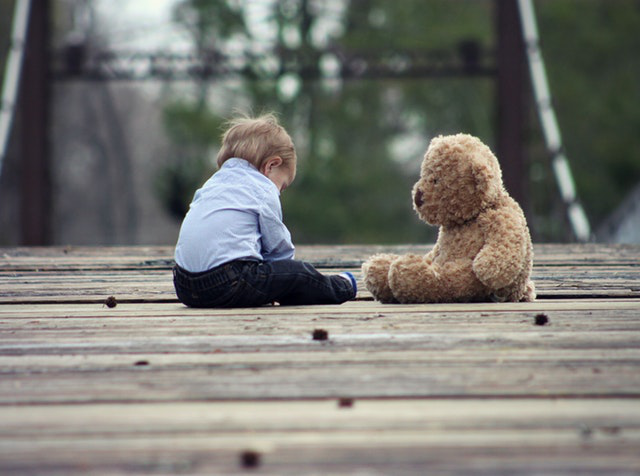

In [7]:
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# Insert credentialas for iamge stored in cloud object storage here



# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client = ibm_boto3.client(service_name='s3',
    ibm_api_key_id=credentials_1['IBM_API_KEY_ID'],
    ibm_auth_endpoint="https://iam.ng.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')


# Your data file was loaded into a botocore.response.StreamingBody object.
# Please read the documentation of ibm_boto3 and pandas to learn more about the possibilities to load the data.
# ibm_boto3 documentation: https://ibm.github.io/ibm-cos-sdk-python/
# pandas documentation: http://pandas.pydata.org/
streaming_body_preview = client.get_object(Bucket=credentials_1['BUCKET'], Key=credentials_1['FILE'])['Body']
streaming_body_predict = client.get_object(Bucket=credentials_1['BUCKET'], Key=credentials_1['FILE'])['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(streaming_body_preview, "__iter__"): streaming_body_preview.__iter__ = types.MethodType( __iter__, streaming_body_preview ) 
if not hasattr(streaming_body_predict, "__iter__"): streaming_body_predict.__iter__ = types.MethodType( __iter__, streaming_body_predict ) 

image = Image.open(streaming_body_preview)
image




## Step 2: Call model to detect objects in the image

In [5]:
model_response = call_model(streaming_body_predict)

## Step 3: Visualize model response

The model returns JSON containing a `predictions` field which is an array of JSON objects, one for each object detected in the image. For each object, the bounding box coordinates are contained in the `detection_box` field, while the object labels can be found in the `label` and `label_id` fields.

The bounding box coordinates are given in the format `[ymin, xmin, ymax, xmax]`, where each coordinate is _normalized_ by the appropriate image dimension (height for `y` or width for `x`). Each coordinate is therefore in the range `[0, 1]`. In order to use these coordinates to display the bounding boxes, we must first map them back to the same range as the original image, so that they become pixel coordinates.

Additionally there is also a `probability` field which indicates the model's confidence of the particular object's class.

In [6]:
# Explore the model results - there should be 2 entries in the `predictions` array
import json
print(json.dumps(model_response, indent=2))

{
  "status": "ok",
  "predictions": [
    {
      "label_id": "88",
      "label": "teddy bear",
      "probability": 0.9896332025527954,
      "detection_box": [
        0.27832502126693726,
        0.5611844062805176,
        0.643224835395813,
        0.8432191610336304
      ]
    },
    {
      "label_id": "1",
      "label": "person",
      "probability": 0.9879012107849121,
      "detection_box": [
        0.24251864850521088,
        0.26926857233047485,
        0.6558930277824402,
        0.5768759846687317
      ]
    }
  ]
}


In [ ]:
# We display bounding boxes and the class label with the predicted probability for each object.

# Get the image height and width
image_width, image_height = image.size
# Create figure and axes
fig, ax = plt.subplots()
# Set larger figure size
fig.set_dpi(600)
# Display the image
plt.imshow(image)

# Set up the color of the bounding boxes and text
color = '#00FF00'
# For each object, draw the bounding box and predicted class together with the probability
for prediction in model_response['predictions']:
    bbox = prediction['detection_box']
    # Unpack the coordinate values
    y1, x1, y2, x2 = bbox
    # Map the normalized coordinates to pixel values: scale by image height for 'y' and image width for 'x'
    y1 *= image_height
    y2 *= image_height
    x1 *= image_width
    x2 *= image_width
    # Format the class probability for display
    probability = '{0:.4f}'.format(prediction['probability'])
    # Format the class label for display
    label = '{}'.format(prediction['label'])
    label = label.capitalize()
    # Create the bounding box rectangle - we need the base point (x, y) and the width and height of the rectangle
    rectangle = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1, edgecolor=color, facecolor='none')
    ax.add_patch(rectangle)
    # Plot the bounding boxes and class labels with confidence scores
    plt.text(x1, y1-5, label, fontsize=4, color=color, fontweight='bold',horizontalalignment='left')
    plt.text(x2, y1-5, probability, fontsize=4, color=color, fontweight='bold',horizontalalignment='right')
plt.axis('off')
plt.show()